In [543]:
from tqdm import tqdm_notebook as tqdm
from IPython.display import Markdown, display
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

In [532]:
def printmd(string):
    display(Markdown(string))

При чтении будем хранить данные в переменной `CACHE`, чтобы ускорить загрузку. В случае их обновления, достаточно вызвать `read(override=True)`

In [288]:
SMALL_DATASET_DIR = '../../nmnist/notMNIST_small/'
LARGE_DATASET_DIR = '../../nmnist/notMNIST_large/'
CACHE = {}

In [512]:
def read(data_dir, override=False):
    global CACHE
    if not CACHE.get(data_dir, []) or override:
        CACHE[data_dir] = []
        X, y = [], []
        for f in tqdm(os.listdir(data_dir), desc='Letter'):
            if not f.startswith('.'):
                img_dir = os.path.join(data_dir, f)
                for img in os.listdir(img_dir):
                    img_path = os.path.join(img_dir, img)
                    data = cv2.imread(img_path, 0)
                    if data is None:
                        continue
                    s = pd.Series(data.reshape((28*28,)))
                    X.append(s)
                    y.append(f)
        CACHE[data_dir].append(pd.DataFrame(X))
        CACHE[data_dir].append(pd.DataFrame(y))
    return CACHE[data_dir][0], CACHE[data_dir][1]

In [513]:
def get_data(data_dir, verbose=False, override=False):
    X, y = read(data_dir, override=override)
    assert X.shape[0] == y.shape[0]
    N = X.shape[0]
    if verbose:
        print(X.shape)
        print(y.shape)
        print(X[:5])
        print(y[:5])
        print(np.unique(y))
    return X, y

In [514]:
def get_split_data(data_dir, size=(0.7, 0.2, 0.1), verbose=False, random_state=6, override=False):
    X, y = shuffle(*get_data(data_dir, verbose=verbose, override=override), random_state=random_state)
    assert abs(np.sum(size) - 1.0) < 0.001
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size[2], random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=size[1], random_state=random_state)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [515]:
X_train, y_train, X_val, y_val, X_test, y_test = get_split_data(LARGE_DATASET_DIR)

По построению (`train_test_split` дает непересекающие подвыборки) `train` и `test` выборки не пересекаются, аналогично `train` и `val`, поэтому, учитывая, что датасет не содержит дубликатов, получаем непересекающие выборки.

Удостоверимся, что данные такие, какими их и ожидали, а также проверим распределение классов на выборках:

Train:
(380961, 784) (380961, 1)


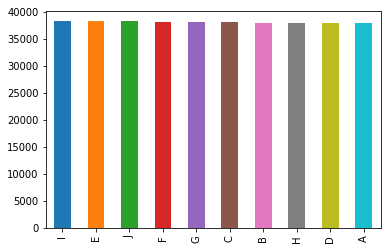

In [516]:
print('Train:')
print(X_train.shape, y_train.shape)
y_train[0].value_counts().plot(kind='bar')

Val:
(95241, 784) (95241, 1)


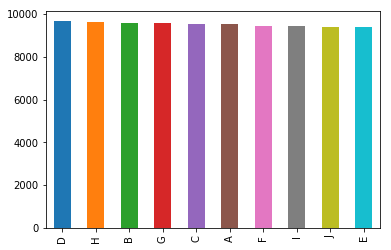

In [517]:
print('Val:')
print(X_val.shape, y_val.shape)
y_val[0].value_counts().plot(kind='bar')

Test:
(52912, 784) (52912, 1)


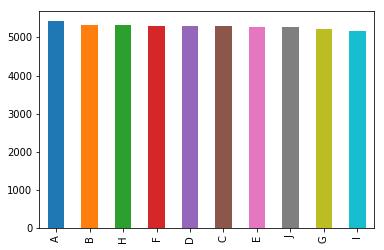

In [518]:
print('Test:')
print(X_test.shape, y_test.shape)
y_test[0].value_counts().plot(kind='bar')

Как видно из графиков, случайное перемешивание датасета дало хорошее почти равномерное распределение классов

Отрисуем некоторые считанные картинки:

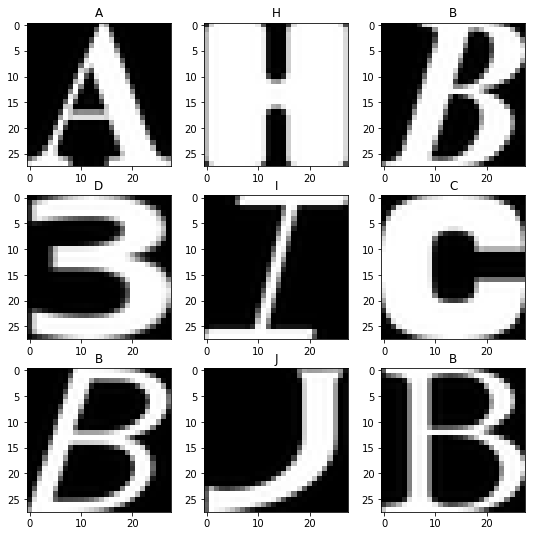

In [519]:
fig, ax = plt.subplots(3, 3, figsize=(9, 9))
for i in range(3):
    for j in range(3):
        idx = i * 3 + j
        ax[i][j].set_title(y_test.iloc[idx][0])
        ax[i][j].imshow(np.array(X_test.iloc[idx]).reshape((28, 28)), cmap='gray')

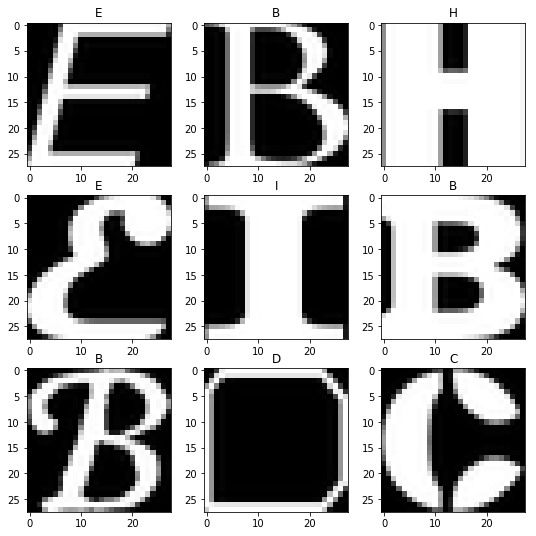

In [520]:
fig, ax = plt.subplots(3, 3, figsize=(9, 9))
for i in range(3):
    for j in range(3):
        idx = i * 3 + j
        ax[i][j].set_title(y_train.iloc[idx][0])
        ax[i][j].imshow(np.array(X_train.iloc[idx]).reshape((28, 28)), cmap='gray')

Убеждаемся в том, что данные получены верно и ответ для каждой картинки сохранен правильно

In [539]:
def try_classifier(X_train, y_train, X_test, y_test, **params):
    classifier = LogisticRegression(solver='sag', multi_class='multinomial', n_jobs=-1, random_state=6, **params)
    classifier.fit(X_train, y_train)
    return classifier, classifier.score(X_test, y_test)

def check_distribution(name, y):
    print(f'Difference max - min for {name} =', np.max(y) - np.min(y))

def try_different(**params):
    val_scores = []
    test_scores = []
    clfs = []
    Ns = np.linspace(5000, 400000, 10)
    for N in tqdm(Ns):
        N = int(N)
        printmd(f'**Classifying {N} samples**')
        N_val = X_val.shape[0] * N // X_train.shape[0]
        print('Train:', N)
        check_distribution('Train', y_train[:N][0].value_counts())
        print('Val:', N_val)
        check_distribution('Val', y_val[:N_val][0].value_counts())
        clf, score = try_classifier(X_train[:N], y_train[:N][0].ravel(), X_val[:N_val], y_val[:N_val][0].ravel(), **params)
        val_scores.append(score)
        N_test = X_test.shape[0] * N // X_train.shape[0]
        print('Test:', N_test)
        check_distribution('Test', y_test[:N_test][0].value_counts())
        test_scores.append(clf.score(X_test[:N_test], y_test[:N_test][0].ravel()))
        clfs.append(clf)
    return clfs, Ns, val_scores, test_scores

In [540]:
def viz_clf(clfs, Ns, val_scores, test_scores):
    plt.title('Validation and Test scores for N train samples')
    plt.xlabel('N')
    plt.ylabel('Score')
    plt.plot(Ns, val_scores, color='green', label='CV')
    plt.plot(Ns, test_scores, color='red', label='Test')
    plt.legend()
    plt.show()

**Classifying 5000 samples**

Train: 5000
Difference max - min for Train = 61
Val: 1250
Difference max - min for Val = 34
Test: 694
Difference max - min for Test = 25


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


**Classifying 48888 samples**

Train: 48888
Difference max - min for Train = 186
Val: 12222
Difference max - min for Val = 133


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test: 6790
Difference max - min for Test = 115


**Classifying 92777 samples**

Train: 92777
Difference max - min for Train = 300
Val: 23194
Difference max - min for Val = 143


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test: 12885
Difference max - min for Test = 102


**Classifying 136666 samples**

Train: 136666
Difference max - min for Train = 395
Val: 34166
Difference max - min for Val = 161


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test: 18981
Difference max - min for Test = 84


**Classifying 180555 samples**

Train: 180555
Difference max - min for Train = 427
Val: 45139
Difference max - min for Val = 160


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test: 25077
Difference max - min for Test = 93


**Classifying 224444 samples**

Train: 224444
Difference max - min for Train = 410
Val: 56111
Difference max - min for Val = 235


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test: 31173
Difference max - min for Test = 117


**Classifying 268333 samples**

Train: 268333
Difference max - min for Train = 426
Val: 67083
Difference max - min for Val = 252


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test: 37269
Difference max - min for Test = 146


**Classifying 312222 samples**

Train: 312222
Difference max - min for Train = 572
Val: 78056
Difference max - min for Val = 261


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test: 43364
Difference max - min for Test = 175


**Classifying 356111 samples**

Train: 356111
Difference max - min for Train = 456
Val: 89028
Difference max - min for Val = 247


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test: 49460
Difference max - min for Test = 213


**Classifying 400000 samples**

Train: 400000
Difference max - min for Train = 356
Val: 100000
Difference max - min for Val = 285


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test: 55556
Difference max - min for Test = 258


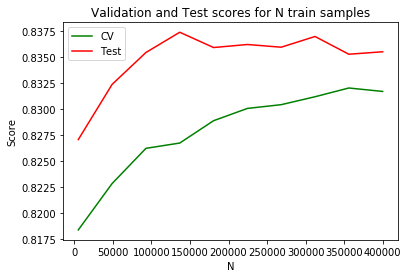

0.8320528373096104
0.8374163637321532


In [541]:
clfs, Ns, val_scores, test_scores = try_different(max_iter=10)
viz_clf(clfs, Ns, val_scores, test_scores)
print(np.max(val_scores))
print(np.max(test_scores))

**Classifying 5000 samples**

Train: 5000
Difference max - min for Train = 61
Val: 1250
Difference max - min for Val = 34
Test: 694
Difference max - min for Test = 25


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


**Classifying 48888 samples**

Train: 48888
Difference max - min for Train = 186
Val: 12222
Difference max - min for Val = 133
Test: 6790
Difference max - min for Test = 115


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


**Classifying 92777 samples**

Train: 92777
Difference max - min for Train = 300
Val: 23194
Difference max - min for Val = 143


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test: 12885
Difference max - min for Test = 102


**Classifying 136666 samples**

Train: 136666
Difference max - min for Train = 395
Val: 34166
Difference max - min for Val = 161


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test: 18981
Difference max - min for Test = 84


**Classifying 180555 samples**

Train: 180555
Difference max - min for Train = 427
Val: 45139
Difference max - min for Val = 160


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test: 25077
Difference max - min for Test = 93


**Classifying 224444 samples**

Train: 224444
Difference max - min for Train = 410
Val: 56111
Difference max - min for Val = 235


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test: 31173
Difference max - min for Test = 117


**Classifying 268333 samples**

Train: 268333
Difference max - min for Train = 426
Val: 67083
Difference max - min for Val = 252


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test: 37269
Difference max - min for Test = 146


**Classifying 312222 samples**

Train: 312222
Difference max - min for Train = 572
Val: 78056
Difference max - min for Val = 261


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test: 43364
Difference max - min for Test = 175


**Classifying 356111 samples**

Train: 356111
Difference max - min for Train = 456
Val: 89028
Difference max - min for Val = 247


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test: 49460
Difference max - min for Test = 213


**Classifying 400000 samples**

Train: 400000
Difference max - min for Train = 356
Val: 100000
Difference max - min for Val = 285


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test: 55556
Difference max - min for Test = 258


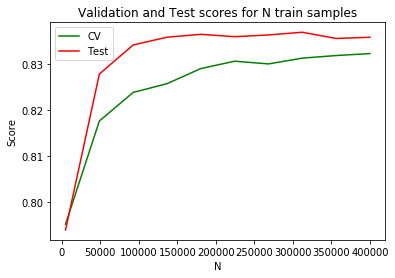

0.8322781155174768
0.8369154137072226


In [542]:
clfs, Ns, val_scores, test_scores = try_different(max_iter=42)
viz_clf(clfs, Ns, val_scores, test_scores)
print(np.max(val_scores))
print(np.max(test_scores))

Как видно из графиков, увеличение верхнего количества итераций не сильно помогает в улучшении качества классификации. Это объясняется тем, что зависимости в реальности сложнее, чем может предоставить модель логистической регрессии. Поэтому дальнейшая настройка гиперпараметров сильного прироста не даст - нужен более существенный переход на другую архитектуру, например использовать нейронные сети, которые позволяют обнаруживать более сложные зависимости.

<div style="text-align: right"> @chiselko6 </div>